<a href="https://colab.research.google.com/github/uzzielperez/lhcbMLbets/blob/main/eleVsPhoCNN0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
from keras.models import Sequential
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal, RandomUniform
from keras import regularizers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.constraints import max_norm
from keras.callbacks import ReduceLROnPlateau

# Electron vs Photon Classification

In this notebook, we use a Convolutional neural network to classify electron vs photon electromagnetic showers. These showers are created by electrons and photons when they interacted with the electromagnetic (EM) calorimeter (ECAL) of the CMS detector at the Large Hadron Collider.

## Electron and Photons

Electrons are charged particles and therefore interact with the B field of the CMS detector. Photons on the other hand are neutral particles. While the EM showers are nearly identical on average, the electrons are slightly skewed in the $\phi$ direction as they deposit their energy on the ECAL at an angle.

Each single crystal in the CMS detector is represented by a single pixel whose intensity represents the energy. Here we use 2D images of the showers constructed from $32 \times 32$ windows around the energy maximum.


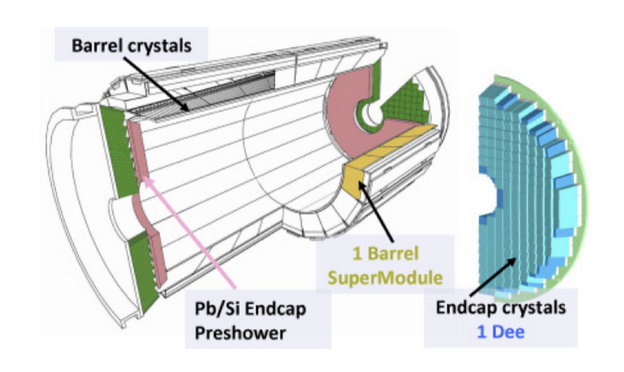

# Additional Resources
* Using the same dataset: https://cds.cern.ch/record/2824815/files/Final%20Report%20-%20Fahed%20AlRashidi.pdf
* Similar project extended to GNNs and using additional detector information: https://www.cmu.edu/ai-physics-institute/outreach/surp/images/2022/manami-kanemura-poster.pdf




In [1]:
from sklearn.metrics import roc_curve, auc

In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
lr_init     = 1.e-3    # Initial learning rate
batch_size  = 100       # Training batch size
train_size  = 100000    # Training size
valid_size  = 10000    # Validation size
test_size   = 10000     # Test size
epochs      = 20       # Number of epochs
doGPU       = True    # Use GPU

In [ ]:
if doGPU:
    import tensorflow as tf

    # Create a TensorFlow config object
    config = tf.config.experimental.set_memory_growth

    # Set GPU memory growth
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Restrict TensorFlow to only use the first GPU
            tf.config.set_visible_devices(gpus[0], 'GPU')
            # Allow memory growth for the GPU
            tf.config.experimental.set_memory_growth(gpus[0], True)
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

 Load Data

In [ ]:
img_rows, img_cols, nb_channels = 32, 32, 2
input_dir = 'drive/MyDrive'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

In [ ]:
def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

Configure Training/Validation/Test Sets

Set range of training set

In [ ]:
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

Plot Photon/ Electron Images

# Input file Data Structure

In [ ]:
hdf5_file = 'drive/MyDrive/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
# with h5py.File(hdf5_file, 'r') as f:
#   # List all top-level groups in the file
#     top_level_keys = list(f.keys())
#     print("Top-level keys:", top_level_keys)

# Open the file in read mode and inspect the structure
with h5py.File(hdf5_file, 'r') as f:
    def print_structure(name, obj):
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        elif isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name}, shape: {obj.shape}, dtype: {obj.dtype}")

    f.visititems(print_structure)

Dataset: X, shape: (249000, 32, 32, 2), dtype: float32
Dataset: y, shape: (249000,), dtype: float32


In [ ]:
# Open the file in read mode
with h5py.File(hdf5_file, 'r') as f:
    # Access the 'X' dataset
    if 'X' in f:
        X = f['X']
        print("X shape:", X.shape)
        print("X dtype:", X.dtype)
    else:
        print("Dataset 'X' not found.")

    # Access the 'y' dataset
    if 'y' in f:
        y = f['y']
        print("y shape:", y.shape)
        print("y dtype:", y.dtype)
    else:
        print("Dataset 'y' not found.")

X shape: (249000, 32, 32, 2)
X dtype: float32
y shape: (249000,)
y dtype: float32


In [ ]:
# # Access a specific dataset
with h5py.File(hdf5_file, 'r') as f:
  X = f['X']
# dataset = f['X']  # Adjust the path based on the structure
# print("Dataset shape:", dataset.shape)
# print("Dataset dtype:", dataset.dtype)

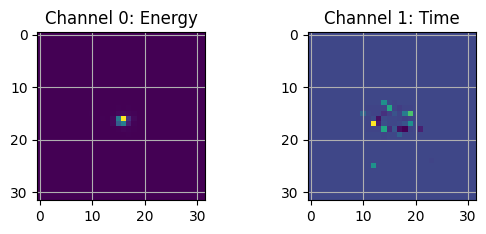

In [ ]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[1, :, :,0])
plt.title("Channel 0: Energy") # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1, :, :, 1])
plt.title("Channel 1: Time") # Time
plt.grid(True)

plt.show()

# Plot 2D Image from Event

ECAL uses $(i\eta, i\phi)$ coordinates for the individual crystals. 2D images of electromagnetic showers constructed from 32 $\times$ 32 windows around the energy max of the particle shower are shown.


Keys in HDF5 file: ['X', 'y']


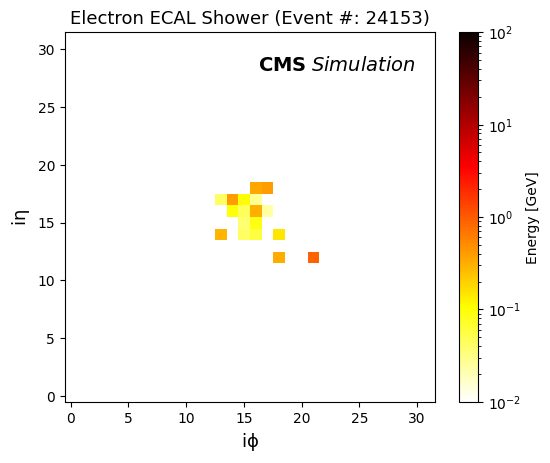

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Define the plotting function
def plot_shower(img, title='', doColorbar=True):
    fig, ax = plt.subplots()
    im = ax.imshow(img, cmap='hot_r', origin='lower', norm=LogNorm(vmin=1e-2, vmax=1e+2))

    if doColorbar:
        ax.figure.colorbar(im, ax=ax, fraction=0.045, pad=0.05, label='Energy [GeV]')
        plt.text(0.55, 0.8, r'$\mathbf{CMS}\;\mathit{Simulation}$', fontsize=14, transform=plt.gcf().transFigure)
    else:
        plt.text(0.48, 0.8, r'$\mathbf{CMS}\;\mathit{Simulation}$', fontsize=14, transform=plt.gcf().transFigure)

    # Labels
    plt.xlabel(r"$\mathrm{i\phi}$", size=13)
    plt.ylabel(r"$\mathrm{i\eta}$", size=13)
    plt.title(title, fontsize=13)
    plt.show()

# Path to your HDF5 file
hdf5_file = 'drive/MyDrive/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'

# Open the HDF5 file
with h5py.File(hdf5_file, 'r') as f:
    # List all datasets in the HDF5 file
    keys = list(f.keys())
    print("Keys in HDF5 file:", keys)

    # Access the dataset for electrons
    electron_data = f['X']  # Ensure this is the correct dataset

    # Get the total number of events
    nEntries_elec = electron_data.shape[0]

    # Randomly pick a single event (event number n)
    n = np.random.randint(0, high=nEntries_elec)
    # Or select event number:
    # Specify the event number you want to visualize
    event_number = 24153
    if event_number >= electron_data.shape[0]:
        raise ValueError(f"Event number {event_number} is out of range. Dataset contains {electron_data.shape[0]} events.")
    n = event_number

    # Get E/gamma shower image from the dataset
    X_elec = electron_data[n, ...]  # Adjust slicing as necessary
    X_elec_grayscale = X_elec.mean(axis=-1)  # Convert to grayscale

    # If X_elec needs to be reshaped
    X_elec_grayscale = X_elec_grayscale.reshape(32, 32)

    # Plot in log
    plot_shower(X_elec_grayscale, title='Electron ECAL Shower (Event #: {})'.format(n))


# Validation

Set range of validation set

In [ ]:
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

Set range of test set

In [ ]:
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

In [ ]:
samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

# Convolutional Neural Network

A convolutional neural network is a deep learning algorithm which is primarily used for handling visual data. It consists of the following components:
* Convolutional layer: performs feature extraction through a convolution operation - which computes the dot product between local regions in the input and the kernel. The kernel, slides over the entire image, performing the same operation and creates a feature map or a smaller image. An activation function is used to introduce nonlinearity. A ReLU for instance, turns all negative values to zero. A sigmoid on the other hand, outputs a value between zero and one, making it useful for classification.

* Pooling layer - A pooling layer is placed in between convolutional layers to reduce the dimensionality of the feature maps to retain information while reducing computational load. These feature maps can be further flattened into a single vector.
* Fully Connected Layer - The flattened single vectors are passed on the fully connected layer (where each neuron in each layer are connected to every other neuron in the next layer) to proceed with classification. A "score" is computed for each category.

The CNN transforms the original image to feature maps to final class/category scores.


## Define CNN model

In [ ]:
model = Sequential()
model.add(Conv2D(8, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal', input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(8, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr_init), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 8)           │             152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 32)          │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 569,889 (2.17 MB)

 Trainable params: 569,889 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 332s 164ms/step - accuracy: 0.5824 - loss: 0.6666 - val_accuracy: 0.6733 - val_loss: 0.6180 - learning_rate: 0.0010
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 376s 161ms/step - accuracy: 0.6778 - loss: 0.6092 - val_accuracy: 0.6997 - val_loss: 0.5837 - learning_rate: 0.0010
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 370s 155ms/step - accuracy: 0.6993 - loss: 0.5870 - val_accuracy: 0.7117 - val_loss: 0.5727 - learning_rate: 0.0010
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 325s 157ms/step - accuracy: 0.7062 - loss: 0.5770 - val_accuracy: 0.7090 - val_loss: 0.5714 - learning_rate: 0.0010
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 330s 165ms/step - accuracy: 0.7112 - loss: 0.5707 - val_accuracy: 0.7182 - val_loss: 0.5634 - learning_rate: 0.0010
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 383s 166ms/step - accuracy: 0.7161 - loss: 0.5639 - val_accuracy: 0.7202 - val_loss: 0.5584 - learning_rate: 0.0010
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 380s 165ms

Save Trained neural network

In [ ]:
model.save('CNNmodel1.h5')

Evaluate on validation set

In [ ]:
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr_val, tpr_val, _ = roc_curve(y_valid, y_pred)
roc_auc_val = auc(fpr_val, tpr_val)
print('Validation ROC AUC:', roc_auc)

625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7235 - loss: 0.5424

Validation loss / accuracy: 0.5380 / 0.7341
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step
Validation ROC AUC: 0.7964593050000001


Evaluate on test set

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred)
roc_auc_test = auc(fpr_test, tpr_test)
print('Test ROC AUC:', roc_auc)

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.7198 - loss: 0.5499

Test loss / accuracy: 0.5470 / 0.7298
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step
Test ROC AUC: 0.7964593050000001


**ROC AUC**

The ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) is a performance metric for classification problems for various thresholds.

It helps describe the trade-off sensitivity between the true positive and false positive false rates.

* A higher AUC indicates better model performance.
* Unlike accuracy, ROC-AUC is a metric that reflect's the model's performance across various possible thresholds.
* Allows comparison for different models or classifiers

Evaluating the ROC-AUC on both the validation and test sets ensures that model is not overfitting and it performs well on new and unseen data.

* **Validation Set** - is used to tune the model's hyperparameters and evaluate its performance during the training phase
* **Test Set** - used to evaluate the final model's performance on unseen data to ensure it *generalizes* well


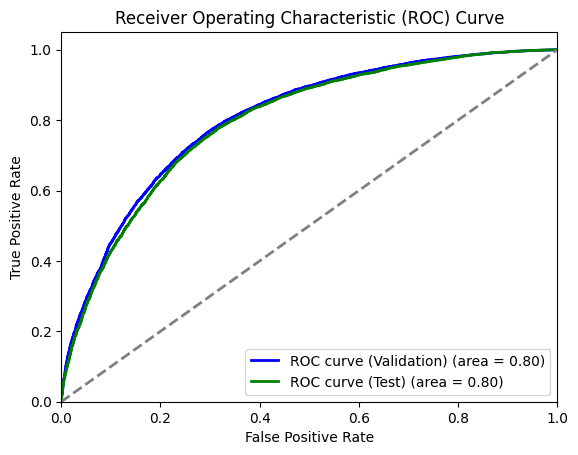

In [ ]:
# Plot ROC-AUC
plt.figure()
plt.plot(fpr_val, tpr_val, color='blue', lw=2, label='ROC curve (Validation) (area = %0.2f)' % roc_auc_val)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve (Test) (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Summary and Conclusion:
